# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment
Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.30 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import pandas as pd 
from collections import deque
import torch
from ddpg_agent import Agent
import matplotlib.pyplot as plt
%matplotlib inline

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


## Solution

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
def ddpg_train(target_score=30, n_episodes=300, learn_every=20, print_every=10, max_t=1000):
    """Deep Deterministic Policy Gradients (DDPG).
    
    """
    scores = []                                  
    scores_deque = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                 # get the current state (for each agent)
        score = np.zeros(num_agents)                          # initialize scores (for each agent)
        agent.reset()                                         # reset noise
        
        # generate trajectories
        for t in range(max_t):
            # act
            actions = agent.act(states, add_noise=True)       # select action based on the current policy
            env_info = env.step(actions)[brain_name]          # interact with the environment
            
            # observe
            next_states = env_info.vector_observations        # get next state (for each agent)
            rewards = env_info.rewards                        # get reward (for each agent)
            dones = env_info.local_done                       # see if episode finished (for each agent)

            # add trajectories to replay buffer
            for (state, action, reward, next_state, done) in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)
                
            # invoke training every 'learn_every' time steps
            if t%learn_every==0:
                for _ in range(10): 
                    agent.invoke_training()                    # train 10 times
            
            score += rewards                                   # update scores (for each agent)
            states = next_states                               # roll over states to next time step
            
            # start next episode if any agent is done
            if np.any(dones):
                break
        
        # book keeping
        scores.append(np.mean(score))
        scores_deque.append(np.mean(score))   # Append the score to score deque

        # print training status
        if i_episode%print_every==0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'
              .format(i_episode, np.mean(scores[-100:]), np.mean(score)))
        
        # training finished when target performance reached
        if np.mean(scores_deque) >= 30.0:  #Check for desired mean score from deque
            print('\nEnvironment solved in {:d} episodes... Average Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
        
    return scores
         

### Training the agent

In [6]:
# initialize the agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=7)

cuda:0


In [7]:
# run training
scores=ddpg_train(target_score=30, n_episodes=500, learn_every=20, print_every=1)

/home/workspace/ddpg_agent.py:107: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 1	Average Score: 0.04	Score: 0.04
Episode 2	Average Score: 0.03	Score: 0.01
Episode 3	Average Score: 0.02	Score: 0.02
Episode 4	Average Score: 0.02	Score: 0.02
Episode 5	Average Score: 0.03	Score: 0.07
Episode 6	Average Score: 0.03	Score: 0.05
Episode 7	Average Score: 0.03	Score: 0.03
Episode 8	Average Score: 0.04	Score: 0.08
Episode 9	Average Score: 0.04	Score: 0.06
Episode 10	Average Score: 0.05	Score: 0.08
Episode 11	Average Score: 0.05	Score: 0.12
Episode 12	Average Score: 0.06	Score: 0.17
Episode 13	Average Score: 0.06	Score: 0.06
Episode 14	Average Score: 0.06	Score: 0.07
Episode 15	Average Score: 0.07	Score: 0.16
Episode 16	Average Score: 0.07	Score: 0.13
Episode 17	Average Score: 0.07	Score: 0.09
Episode 18	Average Score: 0.07	Score: 0.08
Episode 19	Average Score: 0.09	Score: 0.32
Episode 20	Average Score: 0.09	Score: 0.08
Episode 21	Average Score: 0.09	Score: 0.11
Episode 22	Average Score: 0.10	Score: 0.29
Episode 23	Average Score: 0.10	Score: 0.16
Episode 24	Average S

Episode 186	Average Score: 29.78	Score: 36.26
Episode 187	Average Score: 30.00	Score: 35.28

Environment solved in 187 episodes... Average Score: 30.00


### Results

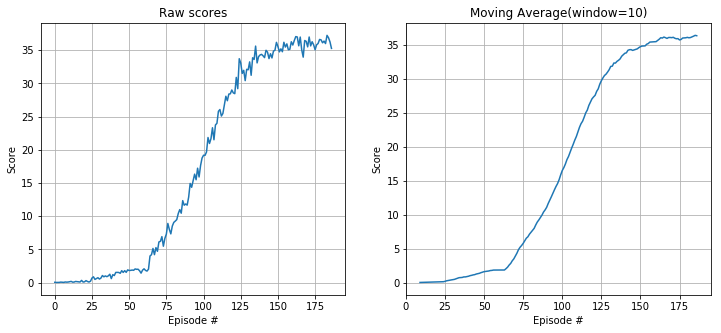

In [8]:
sma_window=10  #Simple Moving Average rolling window
series: pd.Series = pd.Series(scores)
window = series.rolling(window=sma_window)
scores_sma: pd.Series = window.mean()

# plot the scores
fig = plt.figure(figsize=(12, 5))

plot1 = fig.add_subplot(121)
plot1.plot(np.arange(len(scores)), scores)
plot1.set_ylabel('Score')
plot1.set_xlabel('Episode #')
plot1.set_title("Raw scores")
plot1.grid()

plot2 = fig.add_subplot(122)
plot2.plot(np.arange(len(scores_sma)), scores_sma)
plot2.set_ylabel('Score')
plot2.set_xlabel('Episode #')
plot2.set_title(f"Moving Average(window={sma_window})")
plot2.grid()
   
plt.show()

### Let the trained agent interact with the environment

In [9]:
# restore saved agent
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

In [10]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
agent.reset()
while True:
    actions = agent.act(state=states, add_noise=False)                  # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break

print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 38.86049913140014


In [11]:
env.close()